# DOW30 Portfolio Optimization and Backtest
We create a 10-stock portfolio from the DOW30 and compares it against the S&P500 using Mean-Variance Optimization.

In [17]:

# portfolio_dow30_analysis.py

import os
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
from finrl.config_tickers import DOW_30_TICKER
%matplotlib inline



### CONFIG 

In [14]:
PORTFOLIO_TICKERS = DOW_30_TICKER[:10]
SP500_TICKER = "^GSPC"
START_DATE = "2018-01-01"
END_DATE = "2025-01-01"
INITIAL_CAPITAL = 1_000_000
RESULT_DIR = "portfolio_results"
os.makedirs(RESULT_DIR, exist_ok=True)



### DATA 

In [18]:
data = yf.download(PORTFOLIO_TICKERS, start=START_DATE, end=END_DATE, auto_adjust=True)
if isinstance(data.columns, pd.MultiIndex):
    data = data["Close"] if "Close" in data.columns.levels[0] else data

sp500 = yf.download(SP500_TICKER, start=START_DATE, end=END_DATE, auto_adjust=True)["Close"]



[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


### CUMULATIVE RETURNS 

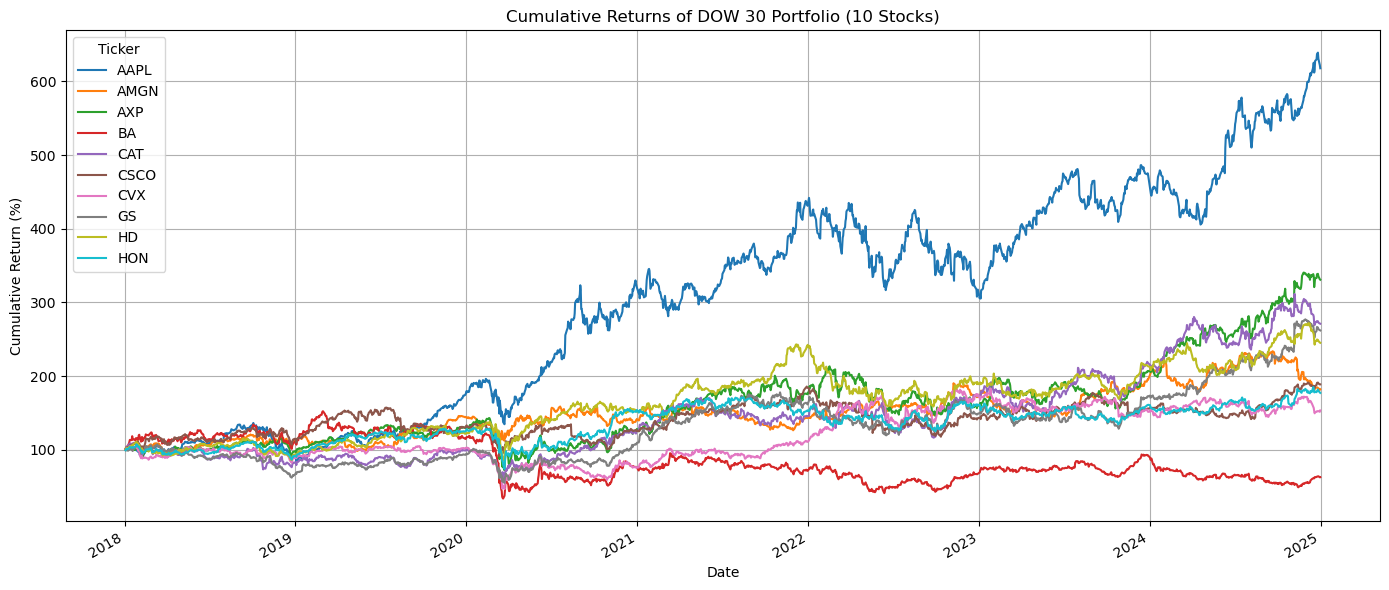

In [19]:
returns = data.pct_change().dropna()
cum_returns = (1 + returns).cumprod() * 100

plt.figure(figsize=(14, 6))
cum_returns.plot(ax=plt.gca(), title="Cumulative Returns of DOW 30 Portfolio (10 Stocks)")
plt.ylabel("Cumulative Return (%)")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/cumulative_returns.png")
plt.show()
plt.show()



### SP500 FOR COMPARISON

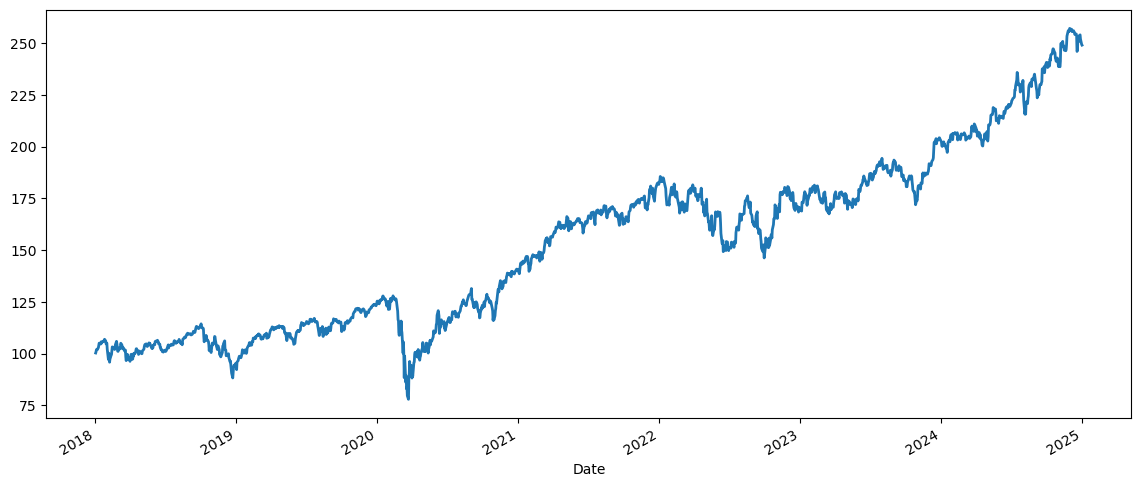

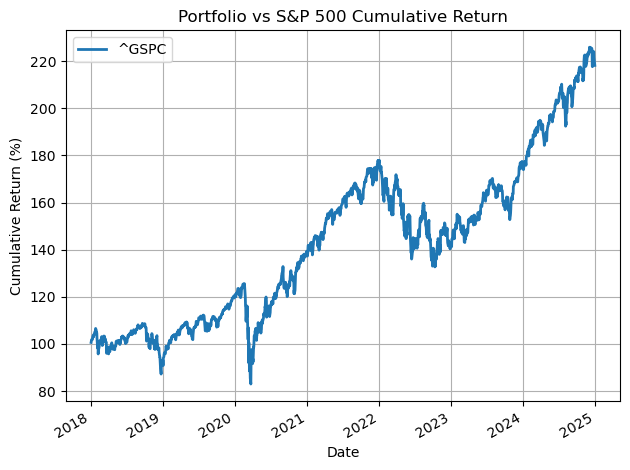

In [20]:
sp500_returns = sp500.pct_change().dropna()
sp500_cum = (1 + sp500_returns).cumprod() * 100

plt.figure(figsize=(14, 6))
cum_returns.mean(axis=1).plot(label="Portfolio", linewidth=2)
sp500_cum.plot(label="S&P 500", linewidth=2)
plt.title("Portfolio vs S&P 500 Cumulative Return")
plt.legend()
plt.ylabel("Cumulative Return (%)")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/portfolio_vs_sp500.png")
plt.show()
plt.show()



### CORRELATION HEATMAP 

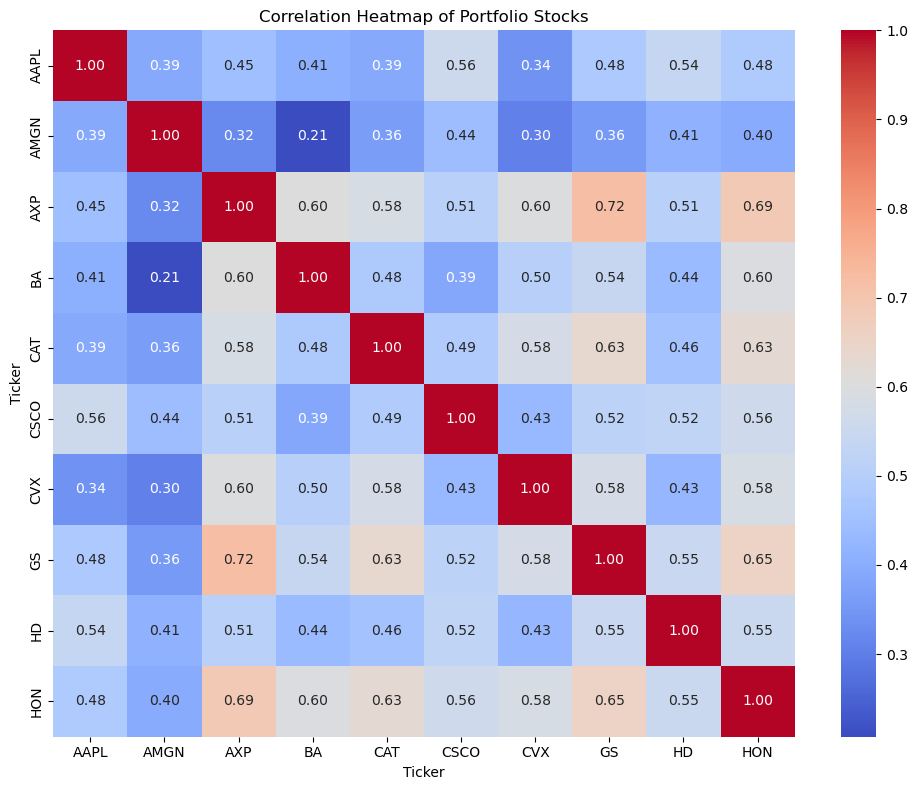

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Portfolio Stocks")
plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/correlation_heatmap.png")
plt.show()
plt.show()



### TRAIN/TEST SPLIT 

In [22]:
split_date = "2023-01-01"
train_data = data[:split_date]
test_data = data[split_date:]

mu = expected_returns.mean_historical_return(train_data)
S = risk_models.sample_cov(train_data)



### EFFICIENT FRONTIER 

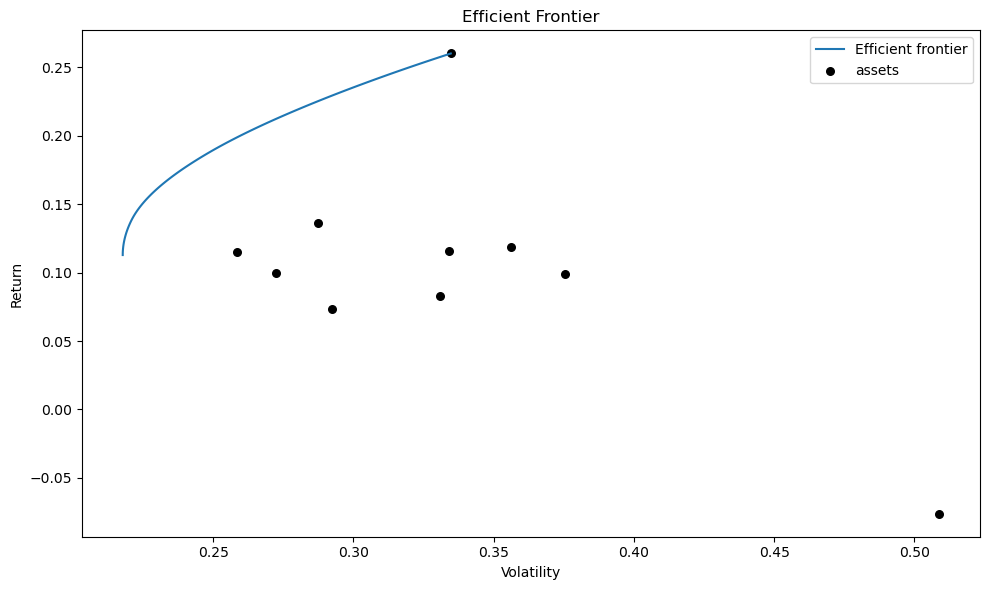

In [23]:
ef = EfficientFrontier(mu, S)
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.title("Efficient Frontier")
plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/efficient_frontier.png")
plt.show()
plt.show()



### MAX SHARPE & MIN VOLATILITY PORTFOLIOS 

In [24]:
ef_max_sharpe = EfficientFrontier(mu, S)
max_sharpe_weights = ef_max_sharpe.max_sharpe()
max_sharpe_perf = ef_max_sharpe.portfolio_performance(verbose=True)

ef_min_vol = EfficientFrontier(mu, S)
min_vol_weights = ef_min_vol.min_volatility()
min_vol_perf = ef_min_vol.portfolio_performance(verbose=True)

# Save weights
with open(f"{RESULT_DIR}/portfolio_weights.txt", "w") as f:
    f.write("Max Sharpe Weights:\n")
    for k, v in max_sharpe_weights.items():
        f.write(f"{k}: {v:.4f}\n")
    f.write("\nMin Volatility Weights:\n")
    for k, v in min_vol_weights.items():
        f.write(f"{k}: {v:.4f}\n")



Expected annual return: 23.3%
Annual volatility: 29.6%
Sharpe Ratio: 0.78
Expected annual return: 11.3%
Annual volatility: 21.8%
Sharpe Ratio: 0.52


### BACKTESTING 

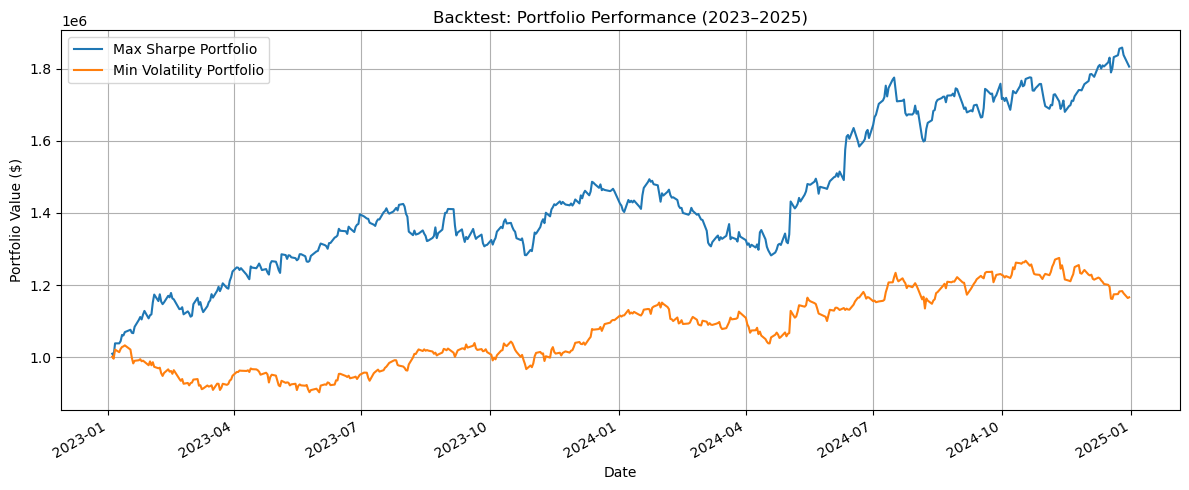

In [26]:
test_returns = test_data.pct_change().dropna()

# Max Sharpe Backtest
sharpe_series = test_returns @ pd.Series(max_sharpe_weights)
sharpe_portfolio = (1 + sharpe_series).cumprod() * INITIAL_CAPITAL

# Min Vol Backtest
minvol_series = test_returns @ pd.Series(min_vol_weights)
minvol_portfolio = (1 + minvol_series).cumprod() * INITIAL_CAPITAL

# Plot backtest
plt.figure(figsize=(12, 5))
sharpe_portfolio.plot(label="Max Sharpe Portfolio")
minvol_portfolio.plot(label="Min Volatility Portfolio")
plt.title("Backtest: Portfolio Performance (2023–2025)")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/backtest_comparison.png")
plt.show()
